In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Road Condition Prediction

The primary goal of this project is to predict road conditions based on car performance and traffic data. By analyzing the speed, engine performance, and traffic conditions, we aim to determine the road condition in a given area. This project utilizes performance data from Peugeot 207 and Opel Corsa under various traffic conditions.

In [3]:
# Read each CSV file, handling parsing errors by filling unexpected fields
def read_csv_error(file_path):
    try:
        return pd.read_csv(file_path, sep=";")
    except pd.errors.ParserError:
        print(f"Error parsing {file_path}. Filling with 'null' values")
        return pd.read_csv(file_path, sep=";", on_bad_lines = 'skip')

In [4]:
peugeot_01 = read_csv_error('Dataset/peugeot_207_01.csv')
peugeot_02 = read_csv_error('Dataset/peugeot_207_02.csv')
opel_01 = read_csv_error('Dataset/opel_corsa_01.csv')
opel_02 = read_csv_error('Dataset/opel_corsa_02.csv')

## Data Preparation

There are 17 columns at the datasets
1. AltitudeVariation = The altitude variation of the cars
2. VehicleSpeedInstantaneous = The car speed at an instant time
3. VehicleSpeedAverage = the latest average car speed
4. VehicleSpeedVariance = the car speed variance
5. VehicleSpeedVariation = the car speed variation
6. LongitudinalAccelation = the acceleration rate of the cars
7. EngineLoad = the engine load of each cars
8. EngineCoolantTemperature = engine temperature of each cars
9. ManifoldAbsolutePressure = engine pressure of the cars
10. EngineRPM = engine RPM at the cars when it's accelerating
11. MassAirflow = airflow of the cars
12. IntakeAirTemperature = the intake air temperature of the cars
13. VerticalAcceleration = the vertical acceleration rate of the cars
14. FuelConsumptionAverage = the fuel consumption average of the cars
15. roadSurface = the road condition
16. traffic = the traffic condition
17. drivingStyle = the driving style of the drivers

We started by checking each dataset

## Peugeot

In [5]:
# Show the datatype and the number of columns
peugeot_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8614 entries, 0 to 8613
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          8551 non-null   object 
 1   VehicleSpeedInstantaneous  8605 non-null   object 
 2   VehicleSpeedAverage        8199 non-null   object 
 3   VehicleSpeedVariance       8199 non-null   object 
 4   VehicleSpeedVariation      8536 non-null   object 
 5   LongitudinalAcceleration   8614 non-null   object 
 6   EngineLoad                 8609 non-null   object 
 7   EngineCoolantTemperature   8609 non-null   float64
 8   ManifoldAbsolutePressure   8609 non-null   float64
 9   EngineRPM                  8609 non-null   object 
 10  MassAirFlow                8609 non-null   object 
 11  IntakeAirTemperature       8609 non-null   float64
 12  VerticalAcceleration       8614 non-null   object 
 13  FuelConsumptionAverage     8518 non-null   objec

In [6]:
# Show the datatype and the number of columns
peugeot_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4623 entries, 0 to 4622
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   AltitudeVariation          4596 non-null   object
 1   VehicleSpeedInstantaneous  4603 non-null   object
 2   VehicleSpeedAverage        4446 non-null   object
 3   VehicleSpeedVariance       4446 non-null   object
 4   VehicleSpeedVariation      4585 non-null   object
 5   LongitudinalAcceleration   4623 non-null   object
 6   EngineLoad                 4623 non-null   object
 7   EngineCoolantTemperature   4623 non-null   int64 
 8   ManifoldAbsolutePressure   4623 non-null   int64 
 9   EngineRPM                  4623 non-null   object
 10  MassAirFlow                4623 non-null   object
 11  IntakeAirTemperature       4623 non-null   int64 
 12  VerticalAcceleration       4623 non-null   object
 13  FuelConsumptionAverage     4582 non-null   object
 14  roadSurf

It showed that each dataset has the same datatype and has the same column. So, because it's a data of the same cars, we can merge them

In [7]:
# Merge the DataFrames
peugeot = pd.concat([peugeot_01, peugeot_02])

# Drop duplicate rows
peugeot = peugeot.drop_duplicates()

# Display the resulting DataFrame
peugeot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13237 entries, 0 to 4622
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          13147 non-null  object 
 1   VehicleSpeedInstantaneous  13208 non-null  object 
 2   VehicleSpeedAverage        12645 non-null  object 
 3   VehicleSpeedVariance       12645 non-null  object 
 4   VehicleSpeedVariation      13121 non-null  object 
 5   LongitudinalAcceleration   13237 non-null  object 
 6   EngineLoad                 13232 non-null  object 
 7   EngineCoolantTemperature   13232 non-null  float64
 8   ManifoldAbsolutePressure   13232 non-null  float64
 9   EngineRPM                  13232 non-null  object 
 10  MassAirFlow                13232 non-null  object 
 11  IntakeAirTemperature       13232 non-null  float64
 12  VerticalAcceleration       13237 non-null  object 
 13  FuelConsumptionAverage     13100 non-null  object 
 

Since a lot of the columns actually have numerical values, we should change the datatype of the columns (except for roadSurface, traffic, and drivingStyle column)

In [8]:
# Group the integer column with 'object' format
column_names = ['AltitudeVariation', 'VehicleSpeedInstantaneous', 'VehicleSpeedAverage', 'VehicleSpeedVariation',
                'VehicleSpeedVariance', 'LongitudinalAcceleration', 'EngineLoad',
                'EngineRPM', 'MassAirFlow', 'VerticalAcceleration', 'FuelConsumptionAverage']

for col in column_names:
    # Apply the replacement only on string values that contain a comma
    peugeot[col] = peugeot[col].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) and ',' in x else x)
    
    # Convert the column to float
    peugeot[col] = peugeot[col].astype(float)

# Add new 'brand' column and filled it with 'peugeot' value
peugeot["brand"] = "peugeot"

# Show the dataset
peugeot.head()

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface,traffic,drivingStyle,brand
0,NaN,0.0,NaN,NaN,NaN,0.0418,36.470589,28.0,100.0,802.5,10.30,14.0,0.0118,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,peugeot
1,NaN,0.0,NaN,NaN,NaN,0.0713,36.470589,28.0,100.0,802.5,10.30,14.0,-0.0023,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,peugeot
2,NaN,0.0,NaN,NaN,NaN,0.0952,36.470589,29.0,100.0,798.5,10.24,14.0,-0.0135,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,peugeot
3,NaN,0.0,NaN,NaN,NaN,0.1136,36.470589,29.0,100.0,798.5,10.24,15.0,-0.0161,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,peugeot
4,NaN,0.0,NaN,NaN,NaN,0.1274,36.470589,29.0,100.0,804.5,10.36,15.0,-0.0160,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,peugeot


In [9]:
# Count the null value number of each column
peugeot.isnull().sum()

AltitudeVariation             90
VehicleSpeedInstantaneous     29
VehicleSpeedAverage          592
VehicleSpeedVariance         592
VehicleSpeedVariation        116
LongitudinalAcceleration       0
EngineLoad                     5
EngineCoolantTemperature       5
ManifoldAbsolutePressure       5
EngineRPM                      5
MassAirFlow                    5
IntakeAirTemperature           5
VerticalAcceleration           0
FuelConsumptionAverage       137
roadSurface                    0
traffic                        0
drivingStyle                   0
brand                          0
dtype: int64

In [10]:
# Drop the null values of these columns
# Because these columns has a little number of null rows
peugeot.dropna(subset=(['EngineLoad','AltitudeVariation', 'VehicleSpeedInstantaneous']), inplace=True)

# Check the null number
peugeot.isnull().sum()

AltitudeVariation              0
VehicleSpeedInstantaneous      0
VehicleSpeedAverage          499
VehicleSpeedVariance         499
VehicleSpeedVariation         24
LongitudinalAcceleration       0
EngineLoad                     0
EngineCoolantTemperature       0
ManifoldAbsolutePressure       0
EngineRPM                      0
MassAirFlow                    0
IntakeAirTemperature           0
VerticalAcceleration           0
FuelConsumptionAverage        39
roadSurface                    0
traffic                        0
drivingStyle                   0
brand                          0
dtype: int64

In [11]:
# Change the null value with mean
mean_vehicle_speed = peugeot['VehicleSpeedAverage'].mean()
mean_fuel_consumption = peugeot['FuelConsumptionAverage'].mean()

# Change the null value with variance
var_vehicle_speed = peugeot['VehicleSpeedVariance'].var()

# Change the null value with mode
mode_vehicle_speed = peugeot['VehicleSpeedVariation'].mode()

# Fill the null value with mean, variance, and mode
peugeot['VehicleSpeedAverage'].fillna(mean_vehicle_speed, inplace=True)
peugeot['VehicleSpeedVariance'].fillna(var_vehicle_speed, inplace=True)
peugeot['VehicleSpeedVariation'].fillna(mode_vehicle_speed, inplace=True)
peugeot['FuelConsumptionAverage'].fillna(mean_fuel_consumption, inplace=True)

# Check the null value number again
peugeot.isnull().sum()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_11764\2580573866.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  peugeot['VehicleSpeedAverage'].fillna(mean_vehicle_speed, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11764\2580573866.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

AltitudeVariation             0
VehicleSpeedInstantaneous     0
VehicleSpeedAverage           0
VehicleSpeedVariance          0
VehicleSpeedVariation        24
LongitudinalAcceleration      0
EngineLoad                    0
EngineCoolantTemperature      0
ManifoldAbsolutePressure      0
EngineRPM                     0
MassAirFlow                   0
IntakeAirTemperature          0
VerticalAcceleration          0
FuelConsumptionAverage        0
roadSurface                   0
traffic                       0
drivingStyle                  0
brand                         0
dtype: int64

In [12]:
# Drop the remaining null values
peugeot.dropna(inplace=True)

In [13]:
# Describe the peugeot datasets
peugeot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13107 entries, 12 to 4622
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          13107 non-null  float64
 1   VehicleSpeedInstantaneous  13107 non-null  float64
 2   VehicleSpeedAverage        13107 non-null  float64
 3   VehicleSpeedVariance       13107 non-null  float64
 4   VehicleSpeedVariation      13107 non-null  float64
 5   LongitudinalAcceleration   13107 non-null  float64
 6   EngineLoad                 13107 non-null  float64
 7   EngineCoolantTemperature   13107 non-null  float64
 8   ManifoldAbsolutePressure   13107 non-null  float64
 9   EngineRPM                  13107 non-null  float64
 10  MassAirFlow                13107 non-null  float64
 11  IntakeAirTemperature       13107 non-null  float64
 12  VerticalAcceleration       13107 non-null  float64
 13  FuelConsumptionAverage     13107 non-null  float64


## Opel

In [14]:
opel_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   AltitudeVariation          7338 non-null   object
 1   VehicleSpeedInstantaneous  7385 non-null   object
 2   VehicleSpeedAverage        7038 non-null   object
 3   VehicleSpeedVariance       7038 non-null   object
 4   VehicleSpeedVariation      7358 non-null   object
 5   LongitudinalAcceleration   7392 non-null   object
 6   EngineLoad                 7392 non-null   object
 7   EngineCoolantTemperature   7392 non-null   int64 
 8   ManifoldAbsolutePressure   7392 non-null   int64 
 9   EngineRPM                  7392 non-null   int64 
 10  MassAirFlow                7392 non-null   object
 11  IntakeAirTemperature       7392 non-null   int64 
 12  VerticalAcceleration       7392 non-null   object
 13  FuelConsumptionAverage     7295 non-null   object
 14  roadSurf

In [15]:
opel_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4328 entries, 0 to 4327
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   AltitudeVariation          4292 non-null   object
 1   VehicleSpeedInstantaneous  4320 non-null   object
 2   VehicleSpeedAverage        4092 non-null   object
 3   VehicleSpeedVariance       4092 non-null   object
 4   VehicleSpeedVariation      4290 non-null   object
 5   LongitudinalAcceleration   4328 non-null   object
 6   EngineLoad                 4328 non-null   object
 7   EngineCoolantTemperature   4328 non-null   int64 
 8   ManifoldAbsolutePressure   4328 non-null   int64 
 9   EngineRPM                  4328 non-null   int64 
 10  MassAirFlow                4328 non-null   object
 11  IntakeAirTemperature       4328 non-null   int64 
 12  VerticalAcceleration       4328 non-null   object
 13  FuelConsumptionAverage     4276 non-null   object
 14  roadSurf

It seems Opel also has the same type of data with Peugeot. So, I can also merge all the opel data

In [16]:
# Merge the DataFrames
opel = pd.concat([opel_01, opel_02])

# Drop duplicate rows
opel = opel.drop_duplicates()

# Display the resulting DataFrame
opel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11720 entries, 0 to 4327
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   AltitudeVariation          11630 non-null  object
 1   VehicleSpeedInstantaneous  11705 non-null  object
 2   VehicleSpeedAverage        11130 non-null  object
 3   VehicleSpeedVariance       11130 non-null  object
 4   VehicleSpeedVariation      11648 non-null  object
 5   LongitudinalAcceleration   11720 non-null  object
 6   EngineLoad                 11720 non-null  object
 7   EngineCoolantTemperature   11720 non-null  int64 
 8   ManifoldAbsolutePressure   11720 non-null  int64 
 9   EngineRPM                  11720 non-null  int64 
 10  MassAirFlow                11720 non-null  object
 11  IntakeAirTemperature       11720 non-null  int64 
 12  VerticalAcceleration       11720 non-null  object
 13  FuelConsumptionAverage     11571 non-null  object
 14  roadSurface 

In [17]:
for col in column_names:
    # Apply the replacement only on string values that contain a comma
    opel[col] = opel[col].apply(lambda x: str(x).replace(',', '.') if isinstance(x, str) and ',' in x else x)
    
    # Convert the column to float
    opel[col] = opel[col].astype(float)

opel["brand"] = "opel"

# Display dataframe information
opel.head()

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,MassAirFlow,IntakeAirTemperature,VerticalAcceleration,FuelConsumptionAverage,roadSurface,traffic,drivingStyle,brand
0,NaN,0.0,NaN,NaN,NaN,0.0156,25.490196,64,100,801.0,7.85,22,-0.0078,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,opel
1,NaN,0.0,NaN,NaN,NaN,0.0156,25.490196,64,100,803.0,7.89,22,-0.0156,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,opel
2,NaN,NaN,NaN,NaN,NaN,0.0273,25.882353,64,100,800.0,7.77,22,-0.0273,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,opel
3,NaN,NaN,NaN,NaN,NaN,0.0391,25.882353,64,100,798.0,7.77,22,-0.0273,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,opel
4,NaN,0.0,NaN,NaN,NaN,0.0469,25.882353,65,100,798.0,7.94,22,-0.0312,NaN,SmoothCondition,LowCongestionCondition,EvenPaceStyle,opel


In [18]:
# Check the null value number of each column
opel.isnull().sum()

AltitudeVariation             90
VehicleSpeedInstantaneous     15
VehicleSpeedAverage          590
VehicleSpeedVariance         590
VehicleSpeedVariation         72
LongitudinalAcceleration       0
EngineLoad                     0
EngineCoolantTemperature       0
ManifoldAbsolutePressure       0
EngineRPM                      0
MassAirFlow                    0
IntakeAirTemperature           0
VerticalAcceleration           0
FuelConsumptionAverage       149
roadSurface                    0
traffic                        0
drivingStyle                   0
brand                          0
dtype: int64

In [19]:
# Drop the null values at some column
opel.dropna(subset=(['AltitudeVariation', 'VehicleSpeedInstantaneous', 'VehicleSpeedVariation']), inplace=True)

# Check the null value number
opel.isnull().sum()

AltitudeVariation              0
VehicleSpeedInstantaneous      0
VehicleSpeedAverage          480
VehicleSpeedVariance         480
VehicleSpeedVariation          0
LongitudinalAcceleration       0
EngineLoad                     0
EngineCoolantTemperature       0
ManifoldAbsolutePressure       0
EngineRPM                      0
MassAirFlow                    0
IntakeAirTemperature           0
VerticalAcceleration           0
FuelConsumptionAverage        57
roadSurface                    0
traffic                        0
drivingStyle                   0
brand                          0
dtype: int64

In [20]:
# Change the null value into mean
mean_vehicle_speed = opel['VehicleSpeedAverage'].mean()
mean_fuel_consumption = opel['FuelConsumptionAverage'].mean()

# Change the null value into variance
var_vehicle_speed = opel['VehicleSpeedVariance'].var()

# Fill the equation
opel['VehicleSpeedAverage'].fillna(mean_vehicle_speed, inplace=True)
opel['VehicleSpeedVariance'].fillna(var_vehicle_speed, inplace=True)
opel['FuelConsumptionAverage'].fillna(mean_fuel_consumption, inplace=True)

# Check the null value number
opel.isnull().sum()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_11764\2680837953.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  opel['VehicleSpeedAverage'].fillna(mean_vehicle_speed, inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_11764\2680837953.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

AltitudeVariation            0
VehicleSpeedInstantaneous    0
VehicleSpeedAverage          0
VehicleSpeedVariance         0
VehicleSpeedVariation        0
LongitudinalAcceleration     0
EngineLoad                   0
EngineCoolantTemperature     0
ManifoldAbsolutePressure     0
EngineRPM                    0
MassAirFlow                  0
IntakeAirTemperature         0
VerticalAcceleration         0
FuelConsumptionAverage       0
roadSurface                  0
traffic                      0
drivingStyle                 0
brand                        0
dtype: int64

In [21]:
# Count the 'object' values of 'peugeot' dataset
value_road_peugeot = peugeot['roadSurface'].value_counts()
value_traffic_peugeot = peugeot['traffic'].value_counts()
value_driving_peugeot = peugeot['drivingStyle'].value_counts()

print(value_road_peugeot)
print('-----------')
print(value_traffic_peugeot)
print('-----------')
print(value_driving_peugeot)

roadSurface
UnevenCondition         5974
SmoothCondition         3886
FullOfHolesCondition    3247
Name: count, dtype: int64
-----------
traffic
LowCongestionCondition       8041
NormalCongestionCondition    2596
HighCongestionCondition      2470
Name: count, dtype: int64
-----------
drivingStyle
EvenPaceStyle      12429
AggressiveStyle      678
Name: count, dtype: int64


In [22]:
# Count the 'object' values of 'opel' dataset
value_road_opel = opel['roadSurface'].value_counts()
value_traffic_opel = opel['traffic'].value_counts()
value_driving_opel = opel['drivingStyle'].value_counts()

print(value_road_opel)
print('-----------')
print(value_traffic_opel)
print('-----------')
print(value_driving_opel)

roadSurface
SmoothCondition    11165
UnevenCondition      445
Name: count, dtype: int64
-----------
traffic
LowCongestionCondition       10532
HighCongestionCondition        545
NormalCongestionCondition      533
Name: count, dtype: int64
-----------
drivingStyle
EvenPaceStyle      9420
AggressiveStyle    2190
Name: count, dtype: int64


Since both Peugeot and Opel has the same feature, and also their value on roadSurface, traffic, and drivingStyle are the same, we can merge both opel and peugeot data.

## Merge both Peugeot and Opel

In [23]:
# Concatenate both opel and peugeot
df = pd.concat([peugeot, opel])

# Describe the result
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24717 entries, 12 to 4327
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AltitudeVariation          24717 non-null  float64
 1   VehicleSpeedInstantaneous  24717 non-null  float64
 2   VehicleSpeedAverage        24717 non-null  float64
 3   VehicleSpeedVariance       24717 non-null  float64
 4   VehicleSpeedVariation      24717 non-null  float64
 5   LongitudinalAcceleration   24717 non-null  float64
 6   EngineLoad                 24717 non-null  float64
 7   EngineCoolantTemperature   24717 non-null  float64
 8   ManifoldAbsolutePressure   24717 non-null  float64
 9   EngineRPM                  24717 non-null  float64
 10  MassAirFlow                24717 non-null  float64
 11  IntakeAirTemperature       24717 non-null  float64
 12  VerticalAcceleration       24717 non-null  float64
 13  FuelConsumptionAverage     24717 non-null  float64


# Exploratory Data Analysis (EDA)

Create a heatmap to show which data has the most importance

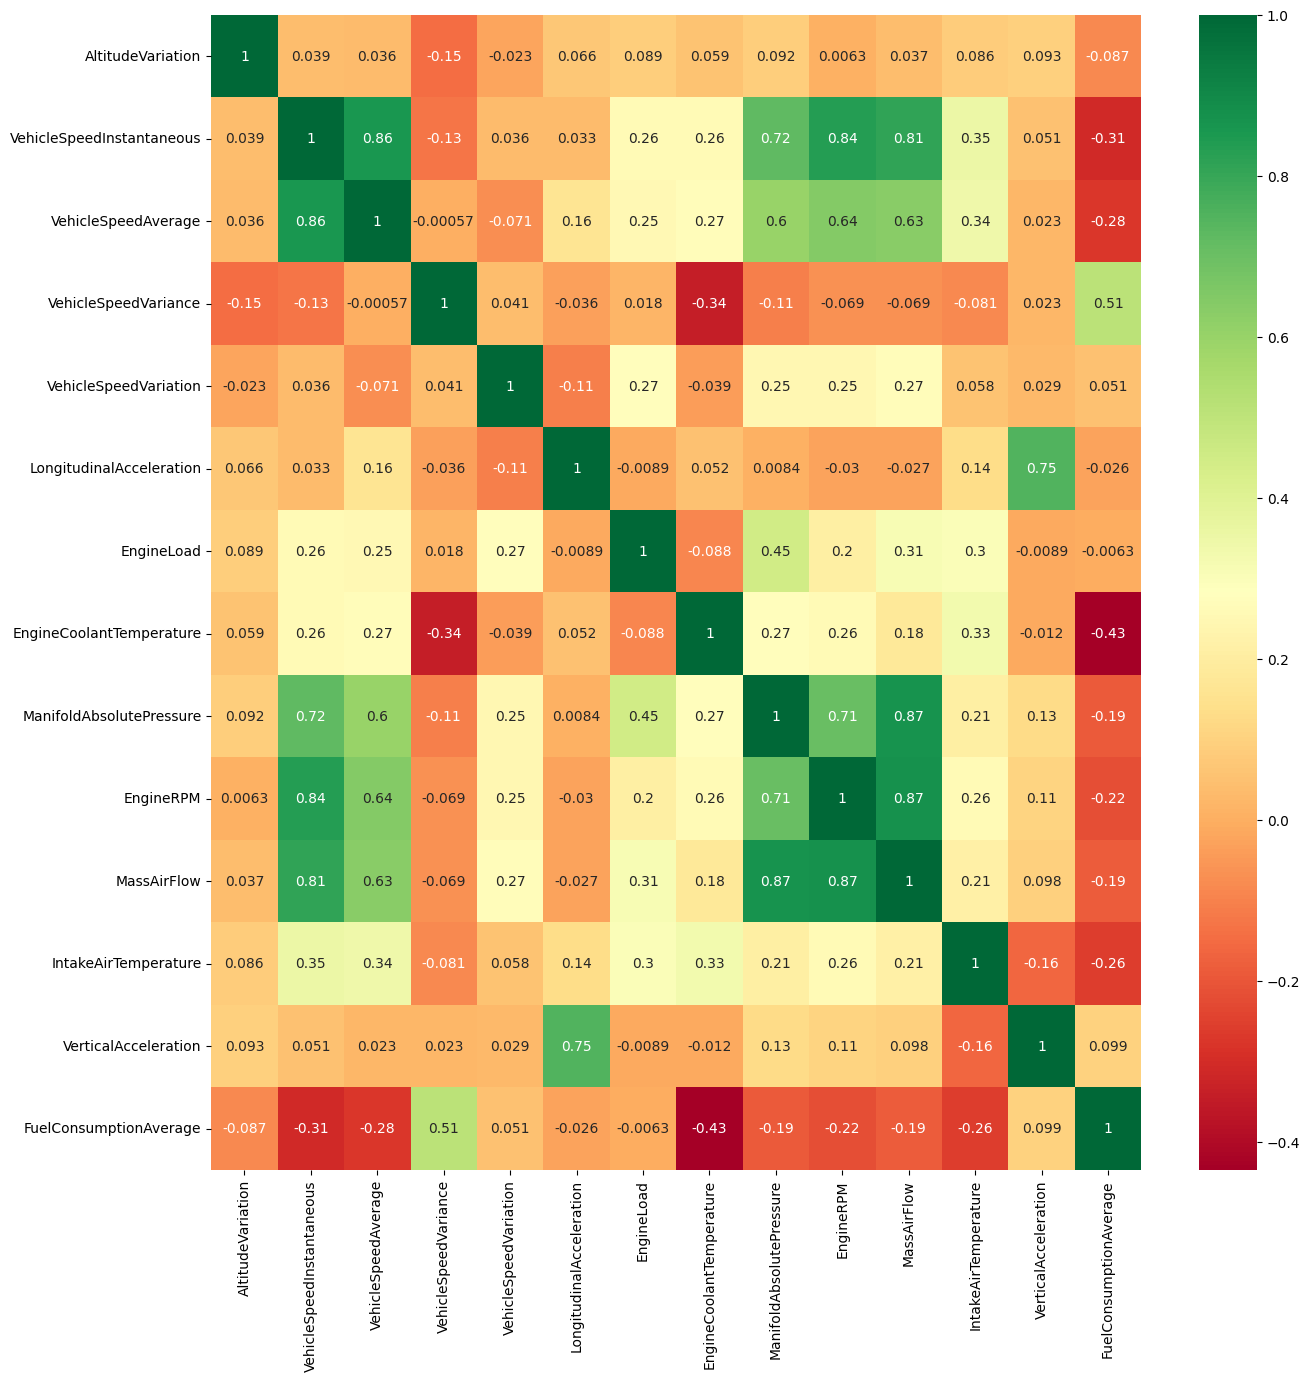

In [24]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix for numeric columns
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn", annot_kws={"size":10})

plt.show()

# Data Splitting

In [25]:
# Split the data into test and train model
train, test = train_test_split(df, test_size=0.25, random_state=21, stratify=df.roadSurface)

In [26]:
print("train: ", train.shape)
print("------------")
print("test: ", test.shape)

train:  (18537, 18)
------------
test:  (6180, 18)


In [27]:
# Do the reset_index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Data Encoding

Encode the data on both test and train data to make all of the data becomes numerical. I use one-hot encoding for road surface, driving style, and brand, because their column only have 2 or 3 values

In [28]:
# Apply one-hot encoding
encode = OneHotEncoder(sparse_output=False)
encoded_train = encode.fit_transform(train[['traffic', 'drivingStyle', 'brand']])
encoded_test = encode.fit_transform(test[['traffic', 'drivingStyle', 'brand']])

# Convert the one-hot encoded array to a DataFrame
one_hot_encoded_train = pd.DataFrame(encoded_train, columns=encode.get_feature_names_out(['traffic', 'drivingStyle', 'brand']))
one_hot_encoded_test = pd.DataFrame(encoded_test, columns=encode.get_feature_names_out(['traffic', 'drivingStyle', 'brand']))

# Combine the original DataFrame (excluding 'roadSurface' and 'drivingStyles') with the one-hot encoded columns
train = pd.concat([train.drop(['traffic', 'drivingStyle', 'brand'], axis=1), one_hot_encoded_train], axis=1)
test = pd.concat([test.drop(['traffic', 'drivingStyle', 'brand'], axis=1), one_hot_encoded_test], axis=1)

train.head()

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,...,VerticalAcceleration,FuelConsumptionAverage,roadSurface,traffic_HighCongestionCondition,traffic_LowCongestionCondition,traffic_NormalCongestionCondition,drivingStyle_AggressiveStyle,drivingStyle_EvenPaceStyle,brand_opel,brand_peugeot
0,-6.599998,98.099998,100.709997,19.102272,0.000000,0.9799,49.411766,79.0,114.0,2311.0,...,-0.1668,9.174463,SmoothCondition,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-1.200012,22.743179,9.937944,57.243614,2.026619,0.4609,1.176471,78.0,104.0,1524.0,...,-0.1484,16.239992,SmoothCondition,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.000000,118.669853,106.119825,123.667484,-0.225189,0.4100,59.215687,83.0,170.0,2366.0,...,-0.3125,11.934516,SmoothCondition,0.0,1.0,0.0,0.0,1.0,1.0,0.0
3,-0.699997,0.000000,32.249999,226.969307,0.000000,1.9103,82.352943,79.0,103.0,662.0,...,-0.7545,9.633719,UnevenCondition,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,5.200012,70.030975,103.770447,78.343681,-4.728783,0.7850,0.000000,84.0,107.0,1306.0,...,-0.3360,10.042739,SmoothCondition,0.0,1.0,0.0,0.0,1.0,1.0,0.0


I use label encoder for the traffic, because, since I also need roadSurface in just 1 column, the value of this column is a bit variative.

In [29]:
# Apply Label Encoder
label_encoder = LabelEncoder()
train['roadSurface_encoded'] = label_encoder.fit_transform(train['roadSurface'])
test['roadSurface_encoded'] = label_encoder.fit_transform(test['roadSurface'])

# Drop the old 'roadSurface' column
train = train.drop(['roadSurface'], axis=1)
test = test.drop(['roadSurface'], axis=1)

train.head()

,AltitudeVariation,VehicleSpeedInstantaneous,VehicleSpeedAverage,VehicleSpeedVariance,VehicleSpeedVariation,LongitudinalAcceleration,EngineLoad,EngineCoolantTemperature,ManifoldAbsolutePressure,EngineRPM,...,VerticalAcceleration,FuelConsumptionAverage,traffic_HighCongestionCondition,traffic_LowCongestionCondition,traffic_NormalCongestionCondition,drivingStyle_AggressiveStyle,drivingStyle_EvenPaceStyle,brand_opel,brand_peugeot,roadSurface_encoded
0,-6.599998,98.099998,100.709997,19.102272,0.000000,0.9799,49.411766,79.0,114.0,2311.0,...,-0.1668,9.174463,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
1,-1.200012,22.743179,9.937944,57.243614,2.026619,0.4609,1.176471,78.0,104.0,1524.0,...,-0.1484,16.239992,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1
2,0.000000,118.669853,106.119825,123.667484,-0.225189,0.4100,59.215687,83.0,170.0,2366.0,...,-0.3125,11.934516,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
3,-0.699997,0.000000,32.249999,226.969307,0.000000,1.9103,82.352943,79.0,103.0,662.0,...,-0.7545,9.633719,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2
4,5.200012,70.030975,103.770447,78.343681,-4.728783,0.7850,0.000000,84.0,107.0,1306.0,...,-0.3360,10.042739,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1


In [30]:
# Split the data into x and y with roadSurface as the supervisor
x_train = train.drop('roadSurface_encoded', axis=1)
y_train = train.roadSurface_encoded

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)

x_train:  (18537, 21)
y_train:  (18537,)


In [31]:
x_test = test.drop('roadSurface_encoded', axis=1)
y_test = test.roadSurface_encoded

print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_test:  (6180, 21)
y_test:  (6180,)


# Feature Selection

In [32]:
# Create the random forest function
def tree_based_feature_importance(x_train, y_train):
    # Create the random forest model
    model = RandomForestClassifier()

    # Fit the model to start training
    model.fit(x_train, y_train)

    # Get the importance of the resulting features.
    importances = model.feature_importances_

    # Create a data frame for visualization.
    final_df = pd.DataFrame({"Features": x_train.columns, "Importances":importances})
    final_df.set_index('Importances')

    # Sort in descending order 
    final_df = final_df.sort_values('Importances', ascending=False)
    
    # Visualising feature importance
    pd.Series(model.feature_importances_, index=x_train.columns).nlargest(6).plot(kind='barh')  
    return final_df

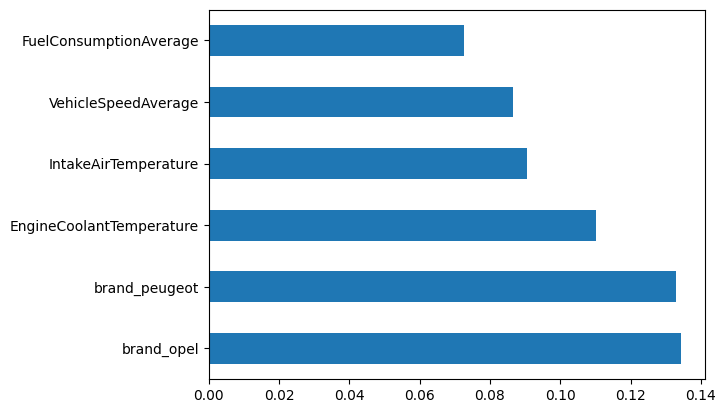

In [33]:
# Use the function to find 5 most important features
feature_importance = tree_based_feature_importance(x_train, y_train)

In [34]:
# Display the feature importance score
display(feature_importance)

,Features,Importances
19,brand_opel,0.134416
20,brand_peugeot,0.132824
7,EngineCoolantTemperature,0.110193
11,IntakeAirTemperature,0.090579
2,VehicleSpeedAverage,0.086416
13,FuelConsumptionAverage,0.072562
15,traffic_LowCongestionCondition,0.065913
1,VehicleSpeedInstantaneous,0.046289
3,VehicleSpeedVariance,0.040784
9,EngineRPM,0.040775


In [35]:
# Making a list of selected features
selected_features = ['brand_opel','brand_peugeot','VehicleSpeedAverage', 'IntakeAirTemperature', 'FuelConsumptionAverage','MassAirFlow',
                    'EngineCoolantTemperature', 'VehicleSpeedVariance', 'VerticalAcceleration','traffic_NormalCongestionCondition',
                    'LongitudinalAcceleration','VehicleSpeedInstantaneous', 'traffic_LowCongestionCondition', 'EngineRPM', 'ManifoldAbsolutePressure']

# Show the selected_features list
x_train[selected_features].head()

,brand_opel,brand_peugeot,VehicleSpeedAverage,IntakeAirTemperature,FuelConsumptionAverage,MassAirFlow,EngineCoolantTemperature,VehicleSpeedVariance,VerticalAcceleration,traffic_NormalCongestionCondition,LongitudinalAcceleration,VehicleSpeedInstantaneous,traffic_LowCongestionCondition,EngineRPM,ManifoldAbsolutePressure
0,0.0,1.0,100.709997,42.0,9.174463,20.379999,79.0,19.102272,-0.1668,0.0,0.9799,98.099998,1.0,2311.0,114.0
1,1.0,0.0,9.937944,16.0,16.239992,11.030000,78.0,57.243614,-0.1484,1.0,0.4609,22.743179,0.0,1524.0,104.0
2,1.0,0.0,106.119825,18.0,11.934516,34.709999,83.0,123.667484,-0.3125,0.0,0.4100,118.669853,1.0,2366.0,170.0
3,0.0,1.0,32.249999,36.0,9.633719,4.330000,79.0,226.969307,-0.7545,0.0,1.9103,0.000000,1.0,662.0,103.0
4,1.0,0.0,103.770447,17.0,10.042739,13.500000,84.0,78.343681,-0.3360,0.0,0.7850,70.030975,1.0,1306.0,107.0


In [36]:
# Creating new datasets with just the selected features
# To make the Machine Learning process becomes more effective
x_train_new = x_train[selected_features]
x_test_new = x_test[selected_features]

In [37]:
# Create an instance scaler
scaler = MinMaxScaler() 

# Fit the scaler to all sets and transform them
x_train_scaled = scaler.fit_transform(x_train_new)
x_test_scaled = scaler.transform(x_test_new)

# Show the x_train_scaled for the first 5 rows
x_train_scaled[:5]

array([[0.00000000e+00, 1.00000000e+00, 8.30045235e-01, 6.03448276e-01,
        9.74346878e-03, 2.69448655e-01, 8.76543210e-01, 5.15100874e-04,
        1.25377271e-01, 0.00000000e+00, 3.50426240e-01, 7.93536396e-01,
        1.00000000e+00, 7.29712662e-01, 1.60493827e-01],
       [1.00000000e+00, 0.00000000e+00, 8.19078855e-02, 1.55172414e-01,
        4.59273614e-02, 1.40251482e-01, 8.64197531e-01, 1.54359837e-03,
        1.26265821e-01, 1.00000000e+00, 3.05463146e-01, 1.83970854e-01,
        0.00000000e+00, 4.81212504e-01, 9.87654321e-02],
       [1.00000000e+00, 0.00000000e+00, 8.74632684e-01, 1.89655172e-01,
        2.38782139e-02, 4.67458879e-01, 9.25925926e-01, 3.33474625e-03,
        1.18341309e-01, 0.00000000e+00, 3.01053471e-01, 9.59927105e-01,
        1.00000000e+00, 7.47079255e-01, 5.06172840e-01],
       [0.00000000e+00, 1.00000000e+00, 2.65802392e-01, 5.00000000e-01,
        1.20954054e-02, 4.76716862e-02, 8.76543210e-01, 6.12032379e-03,
        9.69967983e-02, 0.00000000e+0

# Modelling

Next part is the modelling part, I try some method to create the most accurate classification

## 1. Histogram Gradient Boosting

In [38]:
# Create the model with Gradient Boosting Method
modelH = HistGradientBoostingClassifier()
modelH.fit(x_train_scaled, y_train)

HistGradientBoostingClassifier()

In [39]:
# Create the Prediction
y_pred_boost = modelH.predict(x_test_scaled)

In [40]:
# Show the accuracy score and the classification report of Gradient Boosting Method
print("Accuracy:", accuracy_score(y_test, y_pred_boost))
print(classification_report(y_test, y_pred_boost))

Accuracy: 0.9977346278317152
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       812
           1       1.00      1.00      1.00      3763
           2       1.00      1.00      1.00      1605

    accuracy                           1.00      6180
   macro avg       1.00      1.00      1.00      6180
weighted avg       1.00      1.00      1.00      6180



## 2. Logistic Regression

In [104]:
# Create the model with Logistic Regression Method
model = LogisticRegression(max_iter=1000)
model.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [105]:
# Create the Prediction
y_pred_log = model.predict(x_test_scaled)

# Show the accuracy score and the classification report of Logistic Regression Method
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Accuracy: 0.9058252427184466
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       812
           1       0.96      0.93      0.95      3763
           2       0.83      0.89      0.86      1605

    accuracy                           0.91      6180
   macro avg       0.87      0.88      0.88      6180
weighted avg       0.91      0.91      0.91      6180



## 3. K-Nearest Neighbor

In [106]:
# Create the model using KNN Method
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_scaled, y_train)

KNeighborsClassifier()

In [107]:
# Create the Prediction
y_pred_knn = knn.predict(x_test_scaled)

# Show the accuracy score and the classification report of KNN
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.983495145631068
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       812
           1       0.99      0.99      0.99      3763
           2       0.98      0.98      0.98      1605

    accuracy                           0.98      6180
   macro avg       0.98      0.98      0.98      6180
weighted avg       0.98      0.98      0.98      6180



## 4. Decision Tree

In [108]:
# Create the model using Decision Tree
tree = DecisionTreeClassifier()
tree.fit(x_train_scaled, y_train)

DecisionTreeClassifier()

In [109]:
# Create the Prediction
y_pred_tree = tree.predict(x_test_scaled)

In [110]:
# Show the accuracy score and the classification report of KNN
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Accuracy: 0.9936893203883496
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       812
           1       1.00      0.99      1.00      3763
           2       0.99      0.99      0.99      1605

    accuracy                           0.99      6180
   macro avg       0.99      0.99      0.99      6180
weighted avg       0.99      0.99      0.99      6180



## 5. Naive-Bayes

In [118]:
# Create the model using Naive-Bayes Method
nb = GaussianNB()
nb.fit(x_train_scaled, y_train)

GaussianNB()

In [119]:
# Create the Prediction
y_pred_nb = nb.predict(x_test_scaled)

In [120]:
# Show the accuracy score and the classification report of Naive-Bayes
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Accuracy: 0.679126213592233
              precision    recall  f1-score   support

           0       0.32      1.00      0.49       812
           1       0.97      0.87      0.92      3763
           2       0.39      0.06      0.11      1605

    accuracy                           0.68      6180
   macro avg       0.56      0.64      0.50      6180
weighted avg       0.73      0.68      0.65      6180



# Prediction Result

In [122]:
roadSurface_pred = pd.Series(y_pred_boost)

roadSurface_pred.shape

(6180,)

In [123]:
# Create the table of the value counts
roadSurface_count = roadSurface_pred.value_counts().to_frame()
print(roadSurface_count)
print("-----------")
print("Legend")
print("0 = Full Of Holes Condition")
print("1 = Smooth Condition")
print("2 = Uneven Condition")

   count
1   3766
2   1604
0    810
-----------
Legend
0 = Full Of Holes Condition
1 = Smooth Condition
2 = Uneven Condition


From the result above we can see that based on the most accurate model, most of the road passed by the opel and the peugeot are on the smooth condition

### Saving the model

In [41]:
import joblib

# Save the model
joblib.dump(modelH, 'road_condition_model.pkl')

['road_condition_model.pkl']